In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from tools.DataLoader import SummaryDataset
from tools.FCN import ANN_Classifier
from tools.RNN import RNN_ANNclassifier
from torch.utils.data import DataLoader,random_split
from torch.optim.lr_scheduler import StepLR
import logging
import numpy as np
import matplotlib.pyplot as plt
import emcee

In [7]:
summary_set=np.load('dataset/signal_with_ns/ST_3D_total.npy')
param_set=np.load('dataset/signal_with_ns/params.npy')


#simple normalization of data
sum_mean=np.mean(summary_set,axis=0)
sum_std=np.std(summary_set,axis=0)
summary_set=(summary_set-sum_mean)/sum_std


para_mean=np.array([5,1.7])
para_std=np.array([1,0.7])
param_set=(param_set-param_mean)/para_std

In [6]:
logging.basicConfig(format = '%(asctime)s - %(message)s',
                datefmt = '%m/%d/%Y %H:%M:%S',
                level = logging.INFO)
logger = logging.getLogger(__name__)

epochs=10
batch_size=100
epoch_eval=True

lr=1e-1
val_fra=10

DS=SummaryDataset(summary_set,param_set,norm=False)


n_val = int(len(DS) * val_fra/100)
n_train = len(DS) - n_val
train, val = random_split(DS, [n_train, n_val])

train_data=DataLoader(train,batch_size=batch_size,shuffle=True)
val_data=DataLoader(val,batch_size=batch_size,shuffle=False)

model=ANN_Classifier(data_dim=66,para_dim=2,hidden_dims=[256,128,64,32],apply_dropout=True,dropout=0.2)
logger.info(model)

lossF=nn.BCELoss()
optimizer = optim.SGD(model.parameters(), lr=lr)
scheduler = StepLR(optimizer, step_size=200, gamma=0.8)

device = torch.device('cuda')
model.to(device=device)


best_eval=np.inf
best_epoch=0
for epoch in range(epochs): 

    trained=0
    epoch_loss=0
    correct_sample=0
    model.train()
    logger.info(f'epoch{epoch}-----training')

    for batches in train_data:

        datas=(batches['data'])
        params=batches['param']

        #generate labels
        labels=torch.cat((torch.ones((datas.shape[0],1)),torch.zeros(datas.shape[0],1)),dim=0)

        datas=datas.repeat(2,1)

        re_orderred_params=torch.flip(params,dims=(0,))
        params=torch.cat((params,re_orderred_params),dim=0)

        datas = datas.to(device=device, dtype=torch.float32)
        params = params.to(device=device, dtype=torch.float32)
        labels = labels.to(device=device, dtype=torch.float32)

        model.zero_grad()
        preds= torch.sigmoid(model(datas,params))

        correct_sample+=torch.sum(torch.tensor(preds>0.5,dtype=torch.float32,device=device)==labels).item()

        loss = lossF(preds,labels)
        loss.backward()
        epoch_loss+=loss.item()
        optimizer.step()
        trained+=batch_size

        if(trained%1000==0):
            logger.info(f"{trained}//{n_train}")
    
    if epoch_eval:
        model.eval()
        eval_loss=0
        correct_eval_sample=0
        for val_batches in val_data:

            datas=val_batches['data']
            params=val_batches['param']

            labels=torch.cat((torch.ones((datas.shape[0],1)),torch.zeros(datas.shape[0],1)),dim=0)

            datas=datas.repeat(2,1)

            re_orderred_params=torch.flip(params,dims=(0,))
            params=torch.cat((params,re_orderred_params),dim=0)

            datas = datas.to(device=device, dtype=torch.float32)
            params = params.to(device=device, dtype=torch.float32)
            labels = labels.to(device=device, dtype=torch.float32)

            with torch.no_grad():
                preds= torch.sigmoid(model(datas,params))
            correct_eval_sample+=torch.sum(torch.tensor(preds>0.5,dtype=torch.float32,device=device)==labels).item()
            loss = lossF(preds,labels)    
            eval_loss+=loss.item()

        if eval_loss<best_eval:
            
            # torch.save(model.state_dict(),f'models/best_model.pt')
            best_eval=eval_loss
            best_epoch=epoch
        logger.info(f"************current best:epoch{best_epoch} best_eval={best_eval/len(val_data)}******************")
    
    scheduler.step()
    
    logger.info(f' epoch{epoch}:loss={epoch_loss/len(train_data)} accuracy={correct_sample/((len(train_data)*2*batch_size))}')
    if epoch_eval:
        logger.info(f' epoch{epoch}:eval_loss={eval_loss/len(val_data)} accuracy={correct_eval_sample/((len(val_data)*2*batch_size))} ')

09/14/2023 16:49:27 - INFO - __main__ -   ANN_Classifier(
  (net): ANN(
    (input): Linear(in_features=68, out_features=256, bias=True)
    (hidden_sequence): Sequential(
      (0): ReLU()
      (1): Dropout(p=0.2, inplace=False)
      (2): Linear(in_features=256, out_features=128, bias=True)
      (3): ReLU()
      (4): Dropout(p=0.2, inplace=False)
      (5): Linear(in_features=128, out_features=64, bias=True)
      (6): ReLU()
      (7): Dropout(p=0.2, inplace=False)
      (8): Linear(in_features=64, out_features=32, bias=True)
      (9): ReLU()
    )
    (output): Linear(in_features=32, out_features=1, bias=True)
  )
)
09/14/2023 16:49:27 - INFO - __main__ -   epoch0-----training
/tmp/ipykernel_2610124/3721318425.py:64: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  correct_sample+=torch.sum(torch.tensor(preds>0.5,dtype=torch.float3

In [22]:
#load test data sample

datas=np.load(f"/work/dante/scripts/Inference_21cm/dataset/summary_data/ns_test/faint0-total.npy")
params=np.load("/work/dante/scripts/Inference_21cm/dataset/summary_data/obs_test/faint-y.npy")

true_para=params.copy()

datas=(datas-sum_mean)/sum_std
params=(params-para_mean)/para_std

In [23]:
true_para

array([4.69897   , 1.47712125])

In [24]:
datas=torch.tensor(datas[np.newaxis,:],dtype=torch.float)
params=torch.tensor(params[np.newaxis,:],dtype=torch.float)

datas=datas.to(device='cuda')
params=params.to(device='cuda')

logp =torch.sigmoid(model(datas,params))
p=logp.cpu().detach().numpy()

In [25]:

def log_likelihood(params, datas):

    params=torch.tensor(params[np.newaxis,:],dtype=torch.float32,device='cuda')

    log_R = model(datas,params).detach().cpu().numpy()

#     p = model(datas,params).detach().cpu().numpy()
    
#     log_R = np.log((p+1e-6)/(1-p+1e-6))
    
    return log_R

def log_prior(params):
    params=params*para_std+para_mean
    Tvir,zeta = params
    if 4.0 < Tvir < 6.0 and 1.0<zeta<2.4:
        return 0.0
    return -np.inf

def log_prob(params, datas):
    lp = log_prior(params)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(params,datas)


In [26]:
init_param=np.random.uniform(size=(4, 2))*np.array([2,1.4])+np.array([4,1])
pos=(init_param-para_mean)/para_std


nwalkers, ndim = pos.shape

sampler = emcee.EnsembleSampler(
    nwalkers, ndim, log_prob, args=([datas]))

sampler.run_mcmc(pos, 10000);

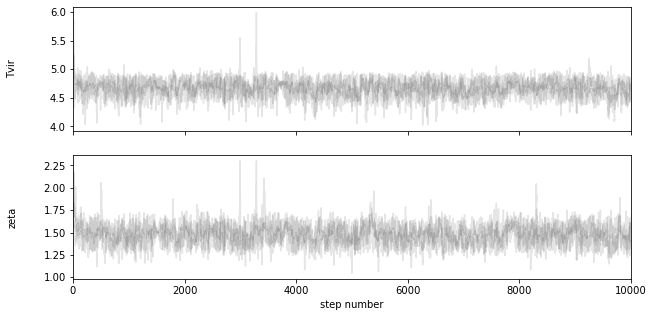

In [27]:
fig, axes = plt.subplots(2, figsize=(10, 5), sharex=True)
samples = sampler.chain
samples=samples*para_std+para_mean
labels = ["Tvir", "zeta"]
for i in range(ndim):
    ax = axes[i]
    for w in range(nwalkers):
        ax.plot(samples[w, :, i], "k", alpha=0.1)
    ax.set_xlim(0, len(samples[0]))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number");

In [114]:
# np.save('/work/dante/scripts/Inference_21cm/Results/NRE_Plot_Results/samples_for_outlier_st',samples)

In [30]:
# flat_samples = sampler.get_chain(discard=100, thin=15, flat=True)
flat_samples=samples[:,2000:,:].reshape(-1,2)
print(flat_samples.shape)

(32000, 2)


In [31]:
from tools.utils import gridplot

/home/dante/.conda/envs/delfi/lib/python3.8/site-packages/seaborn/distributions.py:1182: UserWarning: The following kwargs were not used by contour: 'grid_size'
  cset = contour_func(


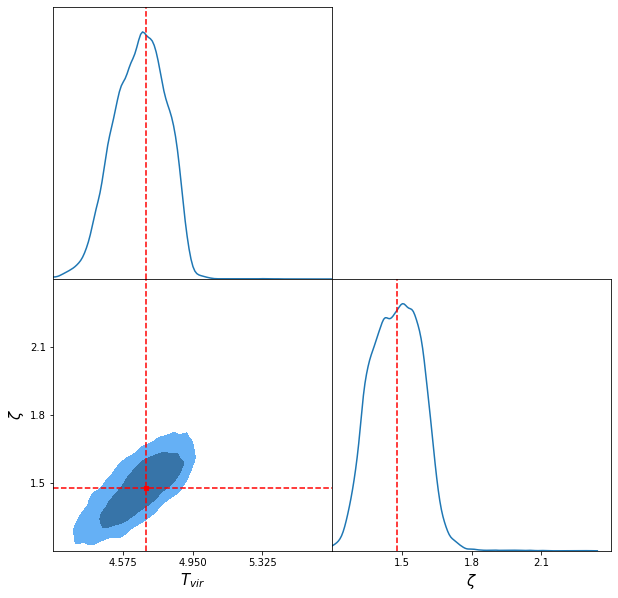

In [32]:
# gridplot(flat_samples,true_para=true_para,para_mins=[5.35,2.20],para_maxs=[5.6,2.40],para_names=['T_{vir}','\zeta'])
# gridplot(flat_samples,true_para=true_para,para_mins=[4.6,1.4],para_maxs=[4.8,1.55],para_names=['T_{vir}','\zeta'])
gridplot(flat_samples,true_para=true_para,para_mins=[4.2,1.2],para_maxs=[5.7,2.4],para_names=['T_{vir}','\zeta'])